# Purpose of notebook: playground for doing word embeddings + semantic polarity

# Where we at: BERT virker, SBERT vil ikke importeres. Er bange for conda

# 🔥 = useful chunks fr

In [1]:
# libraries🔥

# install
%pip install transformers
%pip install torch
%pip install tf-keras # install this because keras needs to work on a previous version of python
%pip install scipy
%pip install pandas
%pip install tensorflow
%pip install -U sentence-transformers
%pip install numpy



# import
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from scipy.spatial.distance import cosine
import pandas as pd
from sentence_transformers import SentenceTransformer
import torch
import numpy as np


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 52.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 31.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 91.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 148.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 109.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 104.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 100.8 MB/s eta 0:00

## test playground for 1 sentence with BERT (bert-base-uncased) - works

In [4]:
# load pretrained tokenizer and model (uncased means it converts all text to lowercase and removes any accent markers before tokenization)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [5]:
# tokenize the input text and convert it into token IDs and attention masks (Token IDs represent the input tokens in numeric form that BERT can process. Attention Masks tell the model which tokens are real words and which are padding (for aligning input lengths))
text = "Abortion is murder of innocent babies."
encoded_input = tokenizer(text, return_tensors='tf') # This tells the tokenizer to return the tokenized output as TensorFlow tensors (which are the required format for TFBertModel). So the returned encoded_input contains input_ids: Numerical IDs for the tokens and attention_mask: A binary mask indicating which positions are padding (0) or actual data (1) (this is important when dealing with more text where sentences or document differ in length).

In [21]:
# Passing the Tokenized Input Through the BERT Model
output = model(encoded_input)
#output # makes no sense to the human eye but I think it works as it should

## test playground for 2 sentences text embedding and semantic similarity

#### Word level - works not very well

In [20]:
# Load pretrained tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained("bert-base-uncased")

# Function to get contextual embedding for a specific word
def get_word_embedding(text, target_word):
    encoded_input = tokenizer(text, return_tensors='tf', padding=True, truncation=True)
    outputs = model(encoded_input)
    
    # Extract token embeddings
    token_embeddings = outputs.last_hidden_state  # [batch_size, seq_len, hidden_dim]
    
    # Find the token index for the target word
    token_ids = encoded_input['input_ids'][0]
    target_word_id = tokenizer.convert_tokens_to_ids(target_word)
    word_indices = tf.where(token_ids == target_word_id)
    
    if len(word_indices) == 0:
        print(f"'{target_word}' not found in the sentence.")
        return None
    
    # Average embeddings if the word appears multiple times
    word_embedding = tf.reduce_mean(tf.gather(token_embeddings[0], word_indices[:, 0]), axis=0)
    return word_embedding

# First sentence
sentence1 = "Abortion is murder of babies."
embedding1 = get_word_embedding(sentence1, 'abortion')

# Second sentence
sentence2 = "Abortion is a safe medical procedure for women."
embedding2 = get_word_embedding(sentence2, 'abortion')

# Check if both embeddings are valid
if embedding1 is not None and embedding2 is not None:
    # Calculate cosine similarity
    similarity_score = 1 - cosine(embedding1.numpy(), embedding2.numpy())
    print(f"Semantic Similarity for 'abortion': {similarity_score:.4f}")
else:
    print("Failed to compute similarity due to missing embeddings.")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Semantic Similarity for 'abortion': 0.9759


In [19]:
def get_sentence_embedding(text):
    encoded_input = tokenizer(text, return_tensors='tf', padding=True, truncation=True)
    output = model(encoded_input)
    # Use [CLS] token embedding for the entire sentence
    cls_embedding = output.last_hidden_state[:, 0, :]  # [CLS] token is at index 0
    return cls_embedding

# Sentence 1
sentence1 = "Abortion is reproductive health care."
embedding1 = get_word_embedding(sentence1, 'abortion')

# Sentence 2
sentence2 = "Abortion is a safe medical procedure for women."
embedding2 = get_word_embedding(sentence2, 'abortion')

# Compute embeddings for entire sentences
embedding1 = get_sentence_embedding(sentence1)
embedding2 = get_sentence_embedding(sentence2)

# Compute cosine similarity
similarity_score = 1 - cosine(embedding1.numpy(), embedding2.numpy())
print(f"Semantic Similarity for entire sentences: {similarity_score:.4f}")


NameError: name 'get_word_embedding' is not defined

### SentenceTransformer model - maybe not appropriate for here

In [74]:
# SBERT

# Load pretrained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and effective model

# Sentences to compare
sentence1 = "Abortion is reproductive health care."
sentence2 = "Abortion is a human health care right."

# Get sentence embeddings
embedding1 = model.encode(sentence1)
embedding2 = model.encode(sentence2)

# Compute cosine similarity
similarity_score = 1 - cosine(embedding1, embedding2)
print(f"Semantic Similarity using SBERT: {similarity_score:.4f}")


Semantic Similarity using SBERT: 0.8555


In [12]:
# Load pretrained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and effective model

# The sentences to encode
sentences = [
    "Abortion is a human right",
    "Abortion is murder on innocent babies",
    "Abortion should be banned in all states",
]

# Calculate embeddings by calling model.encode()
embeddings = model.encode(sentences)
print(embeddings.shape)

# Calculate the embedding similarities
similarities = model.similarity(embeddings, embeddings)
print(similarities)

(3, 384)
tensor([[1.0000, 0.7141, 0.6337],
        [0.7141, 1.0000, 0.6166],
        [0.6337, 0.6166, 1.0000]])


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# List of sentences to be processed
sentences = [
    "Three years later, the coffin was still full of Jello.",
    "The fish dreamed of escaping the fishbowl and into the toilet where he saw his friend go.",
    "The person box was packed with jelly many dozens of months later.",
    "He found a leprechaun in his walnut shell."
]

# Initializing the Sentence Transformer model using BERT with mean-tokens pooling
model = SentenceTransformer('bert-base-nli-mean-tokens')

# Encoding the sentences to obtain their embeddings
sentence_embeddings = model.encode(sentences)

# Calculating the cosine similarity between the first sentence embedding and the rest of the embeddings
# The result will be a list of similarity scores between the first sentence and each of the other sentences
similarity_scores = cosine_similarity([sentence_embeddings[0]], sentence_embeddings[1:])
similarity_scores

### Token-based SentenceTransformer model - verdict tbd

In [18]:
# Load a Token-Based SentenceTransformer model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')  # Example model

# Define the sentences
sentence1 = "Abortion is a controversial topic in politics."
sentence2 = "Abortion is a medical procedure."

# Tokenize and encode the sentences
tokens1 = model.tokenize(sentence1)
tokens2 = model.tokenize(sentence2)

# Get token embeddings for each sentence
with torch.no_grad():
    token_embeddings1 = model(tokens1)['token_embeddings']
    token_embeddings2 = model(tokens2)['token_embeddings']

# Find token embeddings for the word "abortion"
def get_token_embedding(tokens, token_embeddings, target_word):
    # Identify the token index for the word 'abortion'
    word_idx = tokens['input_ids'][0].tolist().index(model.tokenizer.convert_tokens_to_ids(target_word))
    return token_embeddings[0][word_idx].detach().numpy()

embedding1 = get_token_embedding(tokens1, token_embeddings1, 'abortion')
embedding2 = get_token_embedding(tokens2, token_embeddings2, 'abortion')

# Calculate cosine similarity
similarity = 1 - cosine(embedding1, embedding2)
print(f"Cosine similarity for 'abortion': {similarity:.4f}")


ValueError: 11328 is not in list

In [15]:
# Load a Token-Based SentenceTransformer model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# Define the sentences
sentence1 = "Abortion is a controversial topic in politics."
sentence2 = "Abortion is a medical procedure."

# Tokenize and encode the sentences
tokens1 = model.tokenize(sentence1)
tokens2 = model.tokenize(sentence2)

# Get token embeddings for each sentence
with torch.no_grad():
    token_embeddings1 = model(tokens1)['token_embeddings']
    token_embeddings2 = model(tokens2)['token_embeddings']

# Updated function to handle subword tokenization
def get_token_embedding(tokens, token_embeddings, target_word):
    # Get the tokenized word pieces for the target word
    target_word_id = model.tokenizer.convert_tokens_to_ids(target_word)
    
    # Find all token indices for subword parts of the target word
    word_indices = [
        i for i, token_id in enumerate(tokens['input_ids'][0].tolist())
        if token_id == target_word_id
    ]

    if not word_indices:
        print(f"'{target_word}' or its subwords not found in the tokenized sentence.")
        return None
    
    # Average embeddings if multiple subwords
    word_embedding = token_embeddings[0][word_indices].mean(dim=0).detach().numpy()
    return word_embedding

# Find token embeddings for the word "abortion"
embedding1 = get_token_embedding(tokens1, token_embeddings1, 'abortion')
embedding2 = get_token_embedding(tokens2, token_embeddings2, 'abortion')

# Calculate cosine similarity
if embedding1 is not None and embedding2 is not None:
    similarity = 1 - cosine(embedding1, embedding2)
    print(f"Cosine similarity for 'abortion': {similarity:.4f}")


'abortion' or its subwords not found in the tokenized sentence.
'abortion' or its subwords not found in the tokenized sentence.


In [16]:
# Load a Token-Based SentenceTransformer model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# Define the sentences
sentence1 = "Abortion is a controversial topic in politics."
sentence2 = "Abortion is a medical procedure."

# Tokenize and encode the sentences
tokens1 = model.tokenize(sentence1)
tokens2 = model.tokenize(sentence2)

# Get token embeddings for each sentence
with torch.no_grad():
    token_embeddings1 = model(tokens1)['token_embeddings']
    token_embeddings2 = model(tokens2)['token_embeddings']

# Updated function to handle subword tokenization
def get_token_embedding(tokens, token_embeddings, target_word):
    subword_ids = model.tokenizer(target_word, add_special_tokens=False)['input_ids']
    sentence_ids = tokens['input_ids'][0].tolist()
    
    for i in range(len(sentence_ids) - len(subword_ids) + 1):
        if sentence_ids[i:i + len(subword_ids)] == subword_ids:
            word_embedding = token_embeddings[0][i:i + len(subword_ids)].mean(dim=0).detach().numpy()
            return word_embedding
    
    print(f"'{target_word}' or its subwords not found.")
    return None

# Find token embeddings for the word "abortion"
embedding1 = get_token_embedding(tokens1, token_embeddings1, 'abortion')
embedding2 = get_token_embedding(tokens2, token_embeddings2, 'abortion')

# Calculate cosine similarity
if embedding1 is not None and embedding2 is not None:
    similarity = 1 - cosine(embedding1, embedding2)
    print(f"Cosine similarity for 'abortion': {similarity:.4f}")


'abortion' or its subwords not found.
'abortion' or its subwords not found.


array([[0.33088905, 0.72192585, 0.5548365 ]], dtype=float32)

## Keyword specific

Note: you may need to restart the kernel to use updated packages.


In [28]:
from transformers import BertTokenizer, BertModel
import numpy as np

# Step 1: Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get embeddings
def get_embedding(text):
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        output = model(**tokens)
    # Take the mean of the last hidden state (average pooling)
    embedding = output.last_hidden_state.mean(dim=1).squeeze()
    return embedding.numpy()

# Step 2: Embed articles
articles = [
    "Abortion is a highly controversial topic in today's society.",
    "Healthcare providers offer abortion services to women in need.",
    "Some laws heavily restrict abortion access."
]

article_embeddings = [get_embedding(article) for article in articles]

# Step 3: Embed the keyword
keyword = "abortion"
keyword_embedding = get_embedding(keyword).reshape(1, -1)

# Step 4: Calculate semantic similarity
similarities = [cosine_similarity(keyword_embedding, embedding.reshape(1, -1))[0][0] for embedding in article_embeddings]

# Step 5: Display results
for i, similarity in enumerate(similarities):
    print(f"Similarity between '{keyword}' and Article {i+1}: {similarity:.4f}")


Similarity between 'abortion' and Article 1: 0.4611
Similarity between 'abortion' and Article 2: 0.5539
Similarity between 'abortion' and Article 3: 0.5868


In [29]:
# with CNN and Fox articles

from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get embeddings
def get_embedding(text):
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        output = model(**tokens)
    embedding = output.last_hidden_state.mean(dim=1).squeeze()
    return embedding.numpy()

# CNN and Fox News articles
cnn_articles = [
    "Abortion is a highly controversial topic in today's society.",
    "Healthcare providers offer abortion services to women in need."
]

fox_articles = [
    "Some laws heavily restrict abortion access.",
    "Abortion is banned many places."
]

# Embed articles
cnn_embeddings = [get_embedding(article) for article in cnn_articles]
fox_embeddings = [get_embedding(article) for article in fox_articles]

# Embed the keyword
keyword = "abortion"
keyword_embedding = get_embedding(keyword).reshape(1, -1)

# Calculate semantic similarity for each group
cnn_similarities = [cosine_similarity(keyword_embedding, embedding.reshape(1, -1))[0][0] for embedding in cnn_embeddings]
fox_similarities = [cosine_similarity(keyword_embedding, embedding.reshape(1, -1))[0][0] for embedding in fox_embeddings]

# Display results
print("CNN Similarities:")
for i, similarity in enumerate(cnn_similarities):
    print(f"Article {i+1}: {similarity:.4f}")

print("\nFox News Similarities:")
for i, similarity in enumerate(fox_similarities):
    print(f"Article {i+1}: {similarity:.4f}")

# Calculate average similarity for each group
avg_cnn_similarity = np.mean(cnn_similarities)
avg_fox_similarity = np.mean(fox_similarities)

print(f"\nAverage Similarity for CNN: {avg_cnn_similarity:.4f}")
print(f"Average Similarity for Fox News: {avg_fox_similarity:.4f}")


CNN Similarities:
Article 1: 0.4611
Article 2: 0.5539

Fox News Similarities:
Article 1: 0.5868
Article 2: 0.6444

Average Similarity for CNN: 0.5075
Average Similarity for Fox News: 0.6156


In [32]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get contextual embedding for a specific word in a text
def get_contextual_embedding(text, keyword):
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        output = model(**tokens)
    # Get the token index for the keyword
    keyword_index = (tokens.input_ids == tokenizer.encode(keyword, add_special_tokens=False)[0]).nonzero(as_tuple=True)[1]
    # Extract the embedding for the keyword in its context
    keyword_embedding = output.last_hidden_state[0, keyword_index, :].mean(dim=0)
    return keyword_embedding.numpy()

# CNN and Fox News articles
cnn_articles = [
    "Abortion is murder",
    "Abortion is health care"
]

fox_articles = [
    "Abortion is killing babies",
    "Healthcare providers offer abortion services to women in need."
]

# Get contextual embeddings for 'abortion' in each article
cnn_contextual_embeddings = [get_contextual_embedding(article, 'abortion') for article in cnn_articles]
fox_contextual_embeddings = [get_contextual_embedding(article, 'abortion') for article in fox_articles]

# Calculate pairwise similarities between CNN and Fox News contextual embeddings
similarities = []
for cnn_embedding in cnn_contextual_embeddings:
    for fox_embedding in fox_contextual_embeddings:
        similarity = cosine_similarity(cnn_embedding.reshape(1, -1), fox_embedding.reshape(1, -1))[0][0]
        similarities.append(similarity)

# Display results
print("Pairwise Similarities between CNN and Fox News contextual embeddings for 'abortion':")
for i, similarity in enumerate(similarities):
    print(f"Pair {i+1}: {similarity:.4f}")

# Average similarity across CNN vs Fox contexts
avg_similarity = np.mean(similarities)
print(f"\nAverage Similarity between CNN and Fox News usage of 'abortion': {avg_similarity:.4f}")

Pairwise Similarities between CNN and Fox News contextual embeddings for 'abortion':
Pair 1: 0.9636
Pair 2: 0.2296
Pair 3: 0.9687
Pair 4: 0.1585

Average Similarity between CNN and Fox News usage of 'abortion': 0.5801


In [37]:
# PYTORCH
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get contextual embedding for a specific word in a text
def get_contextual_embedding(text, keyword):
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        output = model(**tokens)
    # Get the token index for the keyword
    keyword_index = (tokens.input_ids == tokenizer.encode(keyword, add_special_tokens=False)[0]).nonzero(as_tuple=True)[1]
    # Extract the embedding for the keyword in its context
    keyword_embedding = output.last_hidden_state[0, keyword_index, :].mean(dim=0)
    return keyword_embedding.numpy()

# CNN and Fox News articles
cnn_articles = [
    "Abortion is murder.",
    "Healthcare providers should not offer abortion services to women in need."
]

fox_articles = [
    "Some laws heavily restrict abortion access, and this is taking away women's rights.",
    "Abortion should be legal in all states."
]

# Get contextual embeddings for 'abortion' in each article
cnn_contextual_embeddings = [get_contextual_embedding(article, 'abortion') for article in cnn_articles]
fox_contextual_embeddings = [get_contextual_embedding(article, 'abortion') for article in fox_articles]

# Step 1: Aggregate embeddings within each source
cnn_aggregated_embedding = np.mean(cnn_contextual_embeddings, axis=0)
fox_aggregated_embedding = np.mean(fox_contextual_embeddings, axis=0)

# Step 2: Compare aggregated embeddings between CNN and Fox News
similarity_between_sources = cosine_similarity(
    cnn_aggregated_embedding.reshape(1, -1), 
    fox_aggregated_embedding.reshape(1, -1)
)[0][0]

# Display results
print(f"Similarity between CNN and Fox News aggregated usage of 'abortion': {similarity_between_sources:.4f}")


Similarity between CNN and Fox News aggregated usage of 'abortion': 0.9342


### Using pytorch or tensorflow for semantic similarity gives the exact same result

In [40]:
# TENSORFLOW

# Load pre-trained TensorFlow BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

# Function to get contextual embedding for a specific word in a text
def get_contextual_embedding(text, keyword):
    tokens = tokenizer(text, return_tensors='tf', padding=True, truncation=True, max_length=512)
    with tf.no_gradient():
        output = model(**tokens)
    # Find the token index of the keyword
    keyword_id = tokenizer.encode(keyword, add_special_tokens=False)[0]
    keyword_index = tf.where(tokens.input_ids == keyword_id)[0][1]  # First occurrence index
    # Extract contextual embedding
    keyword_embedding = tf.reduce_mean(output.last_hidden_state[:, keyword_index, :], axis=1)
    return keyword_embedding.numpy()

# CNN and Fox News articles
cnn_articles = [
    "Abortion is murder.",
    "Healthcare providers should not offer abortion services to women in need."
]

fox_articles = [
    "Some laws heavily restrict abortion access, and this is taking away women's rights.",
    "Abortion should be legal in all states."
]

# Get contextual embeddings for 'abortion' in each article
cnn_contextual_embeddings = [get_contextual_embedding(article, 'abortion') for article in cnn_articles]
fox_contextual_embeddings = [get_contextual_embedding(article, 'abortion') for article in fox_articles]

# Step 1: Aggregate embeddings within each source
cnn_aggregated_embedding = np.mean(cnn_contextual_embeddings, axis=0)
fox_aggregated_embedding = np.mean(fox_contextual_embeddings, axis=0)

# Step 2: Compare aggregated embeddings between CNN and Fox News
similarity_between_sources = cosine_similarity(
    cnn_aggregated_embedding.reshape(1, -1), 
    fox_aggregated_embedding.reshape(1, -1)
)[0][0]

# Display results
print(f"Similarity between CNN and Fox News aggregated usage of 'abortion': {similarity_between_sources:.4f}")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

TypeError: no_gradient() missing 1 required positional argument: 'op_type'

In [41]:
# Load pre-trained TensorFlow BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

# Function to get contextual embedding for a specific word in a text
def get_contextual_embedding(text, keyword):
    tokens = tokenizer(text, return_tensors='tf', padding=True, truncation=True, max_length=512)
    output = model(**tokens)
    
    # Find the token index of the keyword
    keyword_id = tokenizer.encode(keyword, add_special_tokens=False)[0]
    keyword_index = tf.where(tokens.input_ids == keyword_id)[0][1]  # First occurrence index
    
    # Extract contextual embedding for the keyword
    keyword_embedding = tf.reduce_mean(output.last_hidden_state[:, keyword_index, :], axis=0)
    return keyword_embedding.numpy()

# CNN and Fox News articles
cnn_articles = [
    "Abortion is murder.",
    "Healthcare providers should not offer abortion services to women in need."
]

fox_articles = [
    "Some laws heavily restrict abortion access, and this is taking away women's rights.",
    "Abortion should be legal in all states."
]

# Get contextual embeddings for 'abortion' in each article
cnn_contextual_embeddings = [get_contextual_embedding(article, 'abortion') for article in cnn_articles]
fox_contextual_embeddings = [get_contextual_embedding(article, 'abortion') for article in fox_articles]

# Step 1: Aggregate embeddings within each source
cnn_aggregated_embedding = np.mean(cnn_contextual_embeddings, axis=0)
fox_aggregated_embedding = np.mean(fox_contextual_embeddings, axis=0)

# Step 2: Compare aggregated embeddings between CNN and Fox News
similarity_between_sources = cosine_similarity(
    cnn_aggregated_embedding.reshape(1, -1), 
    fox_aggregated_embedding.reshape(1, -1)
)[0][0]

# Display results
print(f"Similarity between CNN and Fox News aggregated usage of 'abortion': {similarity_between_sources:.4f}")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Similarity between CNN and Fox News aggregated usage of 'abortion': 0.9342


## trying to do **semantic polarity** like Ding et al. (2023)

In [42]:
# using pytorch not tensorflow

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get contextual embedding for a specific word in a text
def get_contextual_embeddings(texts, keyword):
    embeddings = []
    for text in texts:
        tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            output = model(**tokens)
        # Get the token index for the keyword
        keyword_id = tokenizer.encode(keyword, add_special_tokens=False)[0]
        keyword_index = (tokens.input_ids == keyword_id).nonzero(as_tuple=True)[1]
        
        if len(keyword_index) > 0:  # Only if the keyword exists in the text
            keyword_embedding = output.last_hidden_state[0, keyword_index, :].mean(dim=0)
            embeddings.append(keyword_embedding.numpy())
    return embeddings

# CNN and Fox News articles
cnn_articles = [
    "Abortion is murder.",
    "Healthcare providers should not offer abortion services to women in need."
]

fox_articles = [
    "Some laws heavily restrict abortion access, and this is taking away women's rights.",
    "Abortion should be legal in all states."
]

# Get contextual embeddings for 'abortion' from CNN and Fox News
cnn_embeddings = get_contextual_embeddings(cnn_articles, 'abortion')
fox_embeddings = get_contextual_embeddings(fox_articles, 'abortion')

# Compute Semantic Polarity (SP) between CNN and Fox News
def compute_semantic_polarity(embeddings1, embeddings2):
    total_distance = 0
    count = 0
    for emb1 in embeddings1:
        for emb2 in embeddings2:
            distance = 1 - cosine_similarity(emb1.reshape(1, -1), emb2.reshape(1, -1))[0][0]
            total_distance += distance
            count += 1
    return total_distance / count if count > 0 else 0

semantic_polarity = compute_semantic_polarity(cnn_embeddings, fox_embeddings)

# Display results
print(f"Semantic Polarity (SP) between CNN and Fox News for 'abortion': {semantic_polarity:.4f}")


Semantic Polarity (SP) between CNN and Fox News for 'abortion': 0.4481


### Code works, might work... Testing over time to see if that works and to see how good this whole thing is at measuring semantic polarity

#### Make test dataframe

In [11]:

# Define the data for each column
data = {
    "textID": [12345678, 87654321, 23456789, 98765432, 34567890, 
               76543210, 45678901, 10987654, 56789012, 21098765,
               67890123, 32109876, 78901234, 43210987, 89012345,
               54321098, 90123456, 65432109, 11223344, 44332211],
    "words": [5] * 20,
    "date": [
        "2020-11-03", "2020-12-15", "2021-03-22", "2021-05-10", 
        "2021-10-05", "2021-12-18", "2022-01-29", "2022-05-12",
        "2022-09-25", "2022-12-14", "2023-01-01", "2023-04-19",
        "2023-07-05", "2023-10-08", "2023-12-13", "2024-02-21", 
        "2024-05-07", "2024-08-25", "2024-10-14", "2024-11-05"
    ],
    "country": ["US"] * 20,
    "source": ["CNN", "Fox News"] * 10,
    "url": [f"http://example{num}.com" for num in range(1, 21)],
    "title": [f"Title for article {i}" for i in range(1, 21)],
    "body": [
        "In today’s society, the importance of bodily autonomy cannot be overstated. Women around the world continue to fight for their right to make decisions about their own bodies, and one of the most crucial aspects of this fight is access to safe and legal abortion. Abortion is not just a healthcare issue; it is a fundamental right that empowers women, ensuring they have control over their futures. For decades, studies have shown that when women have access to safe abortion services, societies as a whole benefit. Countries with liberal abortion laws tend to have lower maternal mortality rates, improved public health outcomes, and greater gender equality. Women who can control their reproductive health are more likely to pursue education and career opportunities, contributing to the economic and social well-being of their communities. Opponents of abortion often frame it as a moral or religious issue, but this perspective fails to consider the complex realities many women face. For some, pregnancy may pose serious health risks. Others may be in abusive relationships or lack the financial stability to support a child. Denying these women the right to a safe abortion forces them into situations that can lead to physical, emotional, and economic harm. Moreover, restricting abortion does not stop it from happening—it only makes it more dangerous. According to the World Health Organization, unsafe abortions are a leading cause of maternal death worldwide. In regions where abortion is heavily restricted or banned, women are often forced to seek unsafe, unregulated procedures, putting their lives at risk. In contrast, countries that provide accessible and affordable abortion services have significantly lower rates of complications and fatalities. It’s also important to recognize that abortion is a deeply personal decision. No one is more qualified than the individual woman to determine what is best for her life and her circumstances. Each pregnancy is unique, and so are the challenges and decisions that come with it. For some women, continuing a pregnancy might be the right choice; for others, it might not be. The role of governments and healthcare systems should be to support women, not to impose restrictions that strip them of their agency. Abortion access is also a matter of social justice. Marginalized communities, including low-income women and women of color, are disproportionately affected by restrictive abortion laws. These groups often face systemic barriers to healthcare and are less likely to have access to contraception or comprehensive sex education. When abortion is restricted, they are the ones who suffer the most, perpetuating cycles of poverty and inequality. In conclusion, safe and legal abortion is a cornerstone of women’s rights and healthcare. It empowers women to make choices about their own bodies, protects their health, and promotes equality. The debate around abortion should not be about controlling women’s bodies but about supporting them in making informed decisions that are right for their lives. As societies progress, it is essential to uphold and expand access to safe abortion services, ensuring that every woman has the freedom to choose her own path",
        "Abortion is not okay",
        "Abortion is good",
        "Abortion is bad",
        "Abortion is something I am for",
        "Abortion is something I am against.",
        "Abortion is cool",
        "Abortion is uncool",
        "Abortion is definitely nice",
        "Abortion is definitely not nice.",
        "Abortion is the best",
        "Abortion is the worst",
        "I love Abortion",
        "I hate Abortion",
        "Abortion is best thing ever",
        "Abortion is murder against innocent babies",
        "Abortion is a cornerstone of women's rights.",
        "Abortion should be banned in all states",
        "In today’s society, the importance of bodily autonomy cannot be overstated. Women around the world continue to fight for their right to make decisions about their own bodies, and one of the most crucial aspects of this fight is access to safe and legal abortion. Abortion is not just a healthcare issue; it is a fundamental right that empowers women, ensuring they have control over their futures. For decades, studies have shown that when women have access to safe abortion services, societies as a whole benefit. Countries with liberal abortion laws tend to have lower maternal mortality rates, improved public health outcomes, and greater gender equality. Women who can control their reproductive health are more likely to pursue education and career opportunities, contributing to the economic and social well-being of their communities. When women have the freedom to decide if and when to have children, they can fully participate in society, leading to stronger families, healthier communities, and more robust economies. The ability to access safe and legal abortion also reduces the burden on healthcare systems by preventing complications from unsafe procedures. In contrast, restrictive abortion laws force women into desperate situations, where they might seek dangerous and unregulated services. According to the World Health Organization, unsafe abortions are a leading cause of maternal death worldwide, with millions of women suffering from severe complications every year. The harm caused by these restrictions disproportionately affects marginalized communities, including low-income women and women of color, who often lack access to quality healthcare and family planning resources. Denying these women the right to a safe abortion perpetuates cycles of poverty and inequality, creating barriers that are difficult to overcome. Abortion opponents often argue that life begins at conception and that abortion is equivalent to taking a human life. While these beliefs are deeply held by some, they should not dictate public policy. The reality is that abortion is a deeply personal decision, one that is influenced by a wide range of individual circumstances, including health risks, financial stability, and personal goals. No two pregnancies are the same, and no one is better equipped than the woman herself to make decisions about her own body and her future. Governments should focus on creating policies that support women rather than imposing restrictions that strip them of their agency. When women are denied access to abortion, the consequences can be devastating. Unwanted pregnancies often result in significant financial strain, limiting opportunities for education and employment. Women may be forced to remain in abusive relationships or face social stigma and isolation. In some cases, carrying a pregnancy to term can pose serious health risks, endangering both the mother and the child. These are not theoretical concerns; they are real and affect millions of women around the world every year. Moreover, research has consistently shown that countries with more progressive abortion laws tend to have fewer abortions overall. This is because these countries prioritize comprehensive sex education and access to contraception, empowering individuals to make informed decisions about their reproductive health. By providing the tools and knowledge necessary to prevent unintended pregnancies, these countries create an environment where fewer women need to seek abortion services in the first place. In contrast, restrictive laws often lead to higher abortion rates, as they fail to address the root causes of unintended pregnancies. It is also important to recognize that abortion is a matter of healthcare. Just as individuals have the right to make decisions about other medical procedures, they should have the right to make decisions about abortion without interference from politicians or religious groups. The role of healthcare providers is to offer accurate information, compassionate care, and nonjudgmental support, ensuring that every patient can make the best decision for her unique situation. Abortion is not a one-size-fits-all issue, and it is essential that policies reflect the diverse needs and experiences of women. In addition to being a healthcare issue, abortion is fundamentally about human rights. Access to safe and legal abortion is recognized as a human right by organizations such as the United Nations and the World Health Organization. It is essential to ensure that all individuals, regardless of their socioeconomic status or geographic location, have the ability to exercise this right. When governments restrict access to abortion, they are not only violating human rights but also undermining public health and social progress. The stigma surrounding abortion must also be addressed. For too long, women who seek abortions have been shamed and silenced, forced to carry the weight of societal judgment. This stigma not only affects those who have had abortions but also creates a climate of fear and misinformation, discouraging individuals from seeking the care they need. By normalizing conversations about abortion and highlighting the experiences of women who have made this choice, we can foster a more supportive and understanding society. In conclusion, safe and legal abortion is a cornerstone of women’s rights and healthcare. It empowers women to make choices about their own bodies, protects their health, and promotes equality. The debate around abortion should not be about controlling women’s bodies but about supporting them in making informed decisions that are right for their lives. As societies progress, it is essential to uphold and expand access to safe abortion services, ensuring that every woman has the freedom to choose her own path. The future of reproductive rights depends on our collective commitment to justice, equality, and compassion. Now, more than ever, we must stand together to protect and defend the right to choose, recognizing that when women thrive, we all thrive",
        "Abortion is unjust and takes away innocent lives."
    ]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df


,textID,words,date,country,source,url,title,body
0,12345678,5,2020-11-03,US,CNN,http://example1.com,Title for article 1,"In today’s society, the importance of bodily a..."
1,87654321,5,2020-12-15,US,Fox News,http://example2.com,Title for article 2,Abortion is not okay
2,23456789,5,2021-03-22,US,CNN,http://example3.com,Title for article 3,Abortion is good
3,98765432,5,2021-05-10,US,Fox News,http://example4.com,Title for article 4,Abortion is bad
4,34567890,5,2021-10-05,US,CNN,http://example5.com,Title for article 5,Abortion is something I am for
5,76543210,5,2021-12-18,US,Fox News,http://example6.com,Title for article 6,Abortion is something I am against.
6,45678901,5,2022-01-29,US,CNN,http://example7.com,Title for article 7,Abortion is cool
7,10987654,5,2022-05-12,US,Fox News,http://example8.com,Title for article 8,Abortion is uncool
8,56789012,5,2022-09-25,US,CNN,http://example9.com,Title for article 9,Abortion is definitely nice
9,21098765,5,2022-12-14,US,Fox News,http://example10.com,Title for article 10,Abortion is definitely not nice.


In [16]:
# NO sliding window appraoch

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = BertModel.from_pretrained('bert-large-uncased')

# Function to get contextual embedding for a specific keyword in an article
def get_contextual_embedding(text, keyword):
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        output = model(**tokens)
    keyword_id = tokenizer.encode(keyword, add_special_tokens=False)[0]
    keyword_index = (tokens.input_ids == keyword_id).nonzero(as_tuple=True)[1]
    
    if len(keyword_index) > 0:
        return output.last_hidden_state[0, keyword_index, :].mean(dim=0).numpy()
    else:
        return None  # Return None if keyword isn't found

# Function to compute semantic polarity
def compute_semantic_polarity(cnn_embeddings, fox_embeddings):
    total_distance = 0
    count = 0
    for cnn_emb in cnn_embeddings:
        for fox_emb in fox_embeddings:
            distance = 1 - cosine_similarity(cnn_emb.reshape(1, -1), fox_emb.reshape(1, -1))[0][0]
            total_distance += distance
            count += 1
    return total_distance / count if count > 0 else 0

# Group articles by year
df['year'] = pd.to_datetime(df['date']).dt.year
results = []

for year, group in df.groupby('year'):
    cnn_group = group[group['source'] == 'CNN']
    fox_group = group[group['source'] == 'Fox News']
    
    # Extract embeddings for each article mentioning 'abortion'
    cnn_embeddings = [get_contextual_embedding(body, 'abortion') for body in cnn_group['body'] if get_contextual_embedding(body, 'abortion') is not None]
    fox_embeddings = [get_contextual_embedding(body, 'abortion') for body in fox_group['body'] if get_contextual_embedding(body, 'abortion') is not None]
    
    # Calculate semantic polarity for this year
    sp_score = compute_semantic_polarity(cnn_embeddings, fox_embeddings)
    results.append({'year': year, 'semantic_polarity': sp_score})

# Convert results to a DataFrame
sp_df = pd.DataFrame(results)

# Display results
#import ace_tools as tools; tools.display_dataframe_to_user(name="Semantic Polarity Over Time", dataframe=sp_df)
sp_df

,year,semantic_polarity
0,2020,0.238415
1,2021,0.117612
2,2022,0.085108
3,2023,0.340992
4,2024,0.286112


In [15]:
# Sliding window approach🔥

# Load BERT model and tokenizer (BERT-large is used for more capacity compared to BERT-base)
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = BertModel.from_pretrained('bert-large-uncased')

# Function to extract contextual embedding for a specific keyword using a sliding window approach
def get_contextual_embedding_sliding_window(text, keyword, max_len=512, stride=256):
    """
    Extracts contextual embeddings for a specific keyword using BERT's sliding window approach.
    
    Parameters:
    - text (str): The full article or text to process.
    - keyword (str): The word to extract embeddings for.
    - max_len (int): Maximum length of tokens per chunk (default is 512 for BERT).
    - stride (int): Number of overlapping tokens between chunks (default is 256).
    
    Returns:
    - np.array: The averaged contextual embedding for the keyword across all chunks.
    """
    
    # Tokenize the text into overlapping chunks
    tokens = tokenizer(
        text, 
        return_tensors='pt',  # Return tensors in PyTorch format
        padding=True,  # Pad tokens to max_len
        truncation=True,  # Truncate tokens exceeding max_len
        max_length=max_len,  # Limit chunk size to BERT's maximum of 512 tokens
        stride=stride,  # Overlap between chunks
        return_overflowing_tokens=True  # Return additional chunks as needed
    )
    
    embeddings = []  # To store embeddings for the keyword across chunks
    
    # Loop through each chunk of tokens
    for i in range(tokens['input_ids'].size(0)):  
        # Select only necessary keys for BERT model input
        chunk_tokens = {key: val[i].unsqueeze(0) for key, val in tokens.items() if key in ['input_ids', 'attention_mask', 'token_type_ids']}
        
        with torch.no_grad():  # Disable gradient computation for efficiency
            output = model(**chunk_tokens)  # Pass chunk through BERT model
        
        # Get the token ID for the keyword
        keyword_id = tokenizer.encode(keyword, add_special_tokens=False)[0]
        
        # Find the index of the keyword in the chunk
        keyword_index = (chunk_tokens['input_ids'] == keyword_id).nonzero(as_tuple=True)
        
        if len(keyword_index[1]) > 0:  # If the keyword is found in the chunk
            keyword_embedding = output.last_hidden_state[0, keyword_index[1], :].mean(dim=0).numpy()
            embeddings.append(keyword_embedding)  # Collect the embedding
    
    # Return the averaged embedding across all chunks or None if the keyword is not found
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)
    else:
        return None

# Function to compute semantic polarity between two sets of embeddings
def compute_semantic_polarity(cnn_embeddings, fox_embeddings):
    """
    Computes the semantic polarity score between CNN and Fox News embeddings.
    
    Parameters:
    - cnn_embeddings (list): List of embeddings for CNN articles.
    - fox_embeddings (list): List of embeddings for Fox News articles.
    
    Returns:
    - float: The average cosine distance (semantic polarity) between the two sets of embeddings.
    """
    total_distance = 0  # Sum of cosine distances
    count = 0  # Count of embedding pairs
    
    for cnn_emb in cnn_embeddings:
        for fox_emb in fox_embeddings:
            # Compute cosine similarity, then convert to distance (1 - similarity)
            distance = 1 - cosine_similarity(cnn_emb.reshape(1, -1), fox_emb.reshape(1, -1))[0][0]
            total_distance += distance
            count += 1
    
    return total_distance / count if count > 0 else 0  # Return average distance

# Analyze semantic polarity over time
df['year'] = pd.to_datetime(df['date']).dt.year  # Extract year from the date column
results = []  # Store results for each year

for year, group in df.groupby('year'):  # Group articles by year
    cnn_group = group[group['source'] == 'CNN']  # Filter CNN articles for the year
    fox_group = group[group['source'] == 'Fox News']  # Filter Fox News articles for the year
    
    # Extract embeddings for 'abortion' from each article using sliding window
    cnn_embeddings = [get_contextual_embedding_sliding_window(body, 'abortion') for body in cnn_group['body'] if get_contextual_embedding_sliding_window(body, 'abortion') is not None]
    fox_embeddings = [get_contextual_embedding_sliding_window(body, 'abortion') for body in fox_group['body'] if get_contextual_embedding_sliding_window(body, 'abortion') is not None]
    
    # Compute semantic polarity score for the year
    sp_score = compute_semantic_polarity(cnn_embeddings, fox_embeddings)
    results.append({'year': year, 'semantic_polarity': sp_score})

# Convert the results to a DataFrame
sp_df = pd.DataFrame(results)

# Display the results
print(sp_df)  # Shows semantic polarity scores for each year


   year  semantic_polarity
0  2020           0.238415
1  2021           0.117612
2  2022           0.085108
3  2023           0.340992
4  2024           0.286112


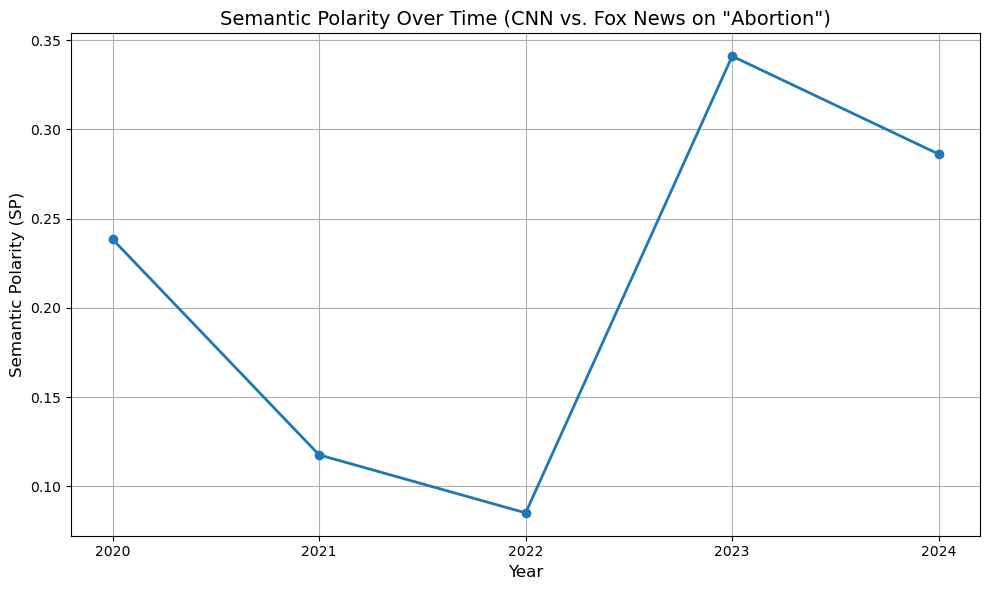

In [17]:
# visualize

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Set the plot size
plt.plot(sp_df['year'], sp_df['semantic_polarity'], marker='o', linestyle='-', linewidth=2)

# Set the title and labels
plt.title('Semantic Polarity Over Time (CNN vs. Fox News on "Abortion")', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Semantic Polarity (SP)', fontsize=12)

# Add grid and customize the x-ticks to show all years
plt.grid(True)
plt.xticks(sp_df['year'])

plt.tight_layout()  # Adjust layout for better spacing
plt.show()  # Display the plot


### I don't know if I like python's visualizations. So I'll save the semantic polarity scores as csv and visualize in r.

In [73]:
# Define the file path where you want to save the CSV🔥
output_file_path = "/work/Bachelor/results_for_plots/sp_df.csv"

# Save the filtered DataFrame as a CSV file
sp_df.to_csv(output_file_path, index=False, encoding='utf-8')

# Thoughts:

## - Very small polarization scores... - I honestly don't know if it's a problem until I see the data. But bert-large-uncased produces higher polarity scores than bert-base-uncased👩‍🍳
## - is BERT good (bert-base-uncased)? Or would a SentenceTransformer be better?? - Daniel days it has to be a model that can do token level. So I guess BERT is fine. bert-large-uncased is better than bert-base-uncased.👹
## - test that it actually takes all the text!! If in doubt, ask Daniel. Sentence-Transformer package might be the fix👩‍🍳
## - Which keywords should I check for? All from the query list, or just abortion, or just the ones that are present in both news outlets (find out from topic modeling on the ind👩‍🍳ividual news sources) --> when you've figured it out, potentially modify code to be able to take more keywords, or duplicate code and use for the different keywords
## - is subword tokenization et issue i det her tilfælde i.e. kommer den til at cutte relevante tokens væk ved at gøre det??👩‍🍳
## - WAIT is it unsmart to get only one unique embedding for the keyword and not keep the unique embeddings? read comment on drev for detailed thoughts + chat might have a code modification if you want to keep all unique embeddings👩‍🍳 